In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import random
import os
from lifelines import KaplanMeierFitter
import lifelines.statistics 

sns.set_theme()
sns.set_context("notebook")
sns.set_palette("colorblind")

In [2]:
data_path = '../data/'

# Multi Class Survival Analysis: Predefined Risks Categories

In [3]:
pub_mult_group = 'BernardEtAl/'

path_verylow = data_path+pub_mult_group+'veryLow.tsv'
df_verylow = pd.read_csv(path_verylow, sep='\t')
path_low = data_path+pub_mult_group+'low.tsv'
df_low = pd.read_csv(path_low, sep='\t')
path_int = data_path+pub_mult_group+'int.tsv'
df_int = pd.read_csv(path_int, sep='\t')
path_high = data_path+pub_mult_group+'high.tsv'
df_high = pd.read_csv(path_high, sep='\t')
path_veryhigh = data_path+pub_mult_group+'veryHigh.tsv'
df_veryhigh = pd.read_csv(path_veryhigh, sep='\t')

In [4]:
# Add a column with the risk group to each of the dataframes
df_verylow['Risk Group'] = 'Very Low'
df_low['Risk Group'] = 'Low'
df_int['Risk Group'] = 'Intermediate'
df_high['Risk Group'] = 'High'
df_veryhigh['Risk Group'] = 'Very High'

# Concatenate the dataframes
df_multiclass_survival = pd.concat([df_verylow, df_low, df_int, df_high, df_veryhigh])

In [5]:
# map censored values to 0 and decesead values to 1
df_multiclass_survival['Status'] = df_multiclass_survival['Status'].map({'censored': 0, 'deceased': 1})

df_multiclass_survival

,Case ID,Study ID,Number at Risk,Status,Survival Rate,Time (months),Risk Group
0,E-H-117419,mds_iwg_2022,482,0,1.000000,0.000000,Very Low
1,E-H-105850,mds_iwg_2022,481,0,1.000000,0.000000,Very Low
2,E-H-105880,mds_iwg_2022,480,0,1.000000,0.000000,Very Low
3,E-H-110409,mds_iwg_2022,479,0,1.000000,0.000000,Very Low
4,E-H-110822,mds_iwg_2022,478,0,1.000000,0.000000,Very Low
...,...,...,...,...,...,...,...
355,E-H-105678,mds_iwg_2022,5,0,0.058110,77.786301,Very High
356,E-H-116517,mds_iwg_2022,4,1,0.043582,79.923288,Very High
357,E-H-105691,mds_iwg_2022,3,0,0.043582,97.380822,Very High
358,E-H-105650,mds_iwg_2022,2,0,0.043582,129.665753,Very High


In [6]:
kmf = KaplanMeierFitter()
T = df_multiclass_survival['Time (months)']
E = df_multiclass_survival['Status']

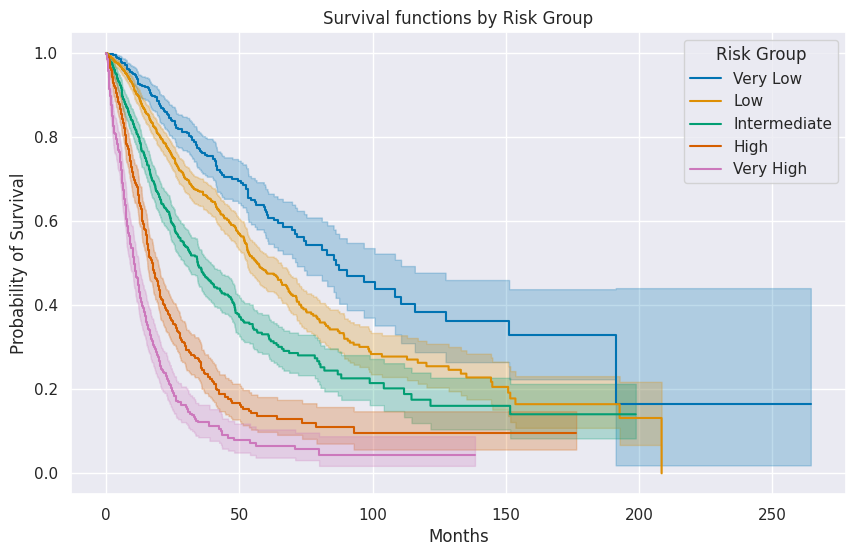

In [7]:
kmf = KaplanMeierFitter()

# Get the unique risk groups
risks_types = df_multiclass_survival['Risk Group'].unique()

# Prepare the plot
plt.figure(figsize=(10, 6))  # Set a figure size

# Loop through each risk group
median_survivals = []
confidence_intervals = []
for risk_type in risks_types:
    # Select data for the current risk group
    ix = df_multiclass_survival['Risk Group'] == risk_type
    # Fit the Kaplan-Meier model
    kmf.fit(T[ix], E[ix], label=risk_type)
    # Plot the survival function for the current group
    kmf.plot_survival_function(ci_show=True)
    # Get the median survival and the respective confidence interval
    median_survival = kmf.median_survival_time_
    median_survivals.append(median_survival)
    confidence_interval = kmf.confidence_interval_survival_function_
    confidence_intervals.append(confidence_interval)

# Customize the plot
plt.title('Survival functions by Risk Group')
plt.xlabel('Months')
plt.ylabel('Probability of Survival')
plt.legend(title='Risk Group')

# Show the plot
plt.show()

In [8]:
results = lifelines.statistics.pairwise_logrank_test(df_multiclass_survival['Time (months)'], df_multiclass_survival['Risk Group'], df_multiclass_survival['Status'])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
                           test_statistic      p  -log2(p)
High         Intermediate           57.64 <0.005     44.85
             Low                   232.61 <0.005    172.05
             Very High              34.13 <0.005     27.53
             Very Low              244.19 <0.005    180.44
Intermediate Low                    42.25 <0.005     33.54
             Very High             180.06 <0.005    133.96
             Very Low               82.76 <0.005     63.23
Low          Very High             485.68 <0.005    355.13
             Very Low               20.90 <0.005     17.66
Very High    Very Low              413.68 <0.005    303.08

In [9]:
print(median_survivals)

print(confidence_intervals)
    

[86.10410959, 56.67945205, 34.3890411, 17.29315068, 10.52054795]
[            Very Low_lower_0.95  Very Low_upper_0.95
0.000000               1.000000             1.000000
0.230137               1.000000             1.000000
0.263014               0.985056             0.999701
0.460274               0.985056             0.999701
0.493151               0.985056             0.999701
...                         ...                  ...
174.641096             0.223718             0.438248
176.975343             0.223718             0.438248
184.701370             0.223718             0.438248
191.276712             0.018784             0.440738
264.526027             0.018784             0.440738

[434 rows x 2 columns],             Low_lower_0.95  Low_upper_0.95
0.000000          1.000000        1.000000
0.032877          1.000000        1.000000
0.098630          1.000000        1.000000
0.131507          1.000000        1.000000
0.295890          0.993309        0.999867
...            

In [10]:
print(median_survivals)
#for each median survival time, calculate the confidence interval
confidence_intervals = []
for median_survival in median_survivals:
    confidence_interval = kmf.confidence_interval_survival_function_
    confidence_intervals.append(confidence_interval.mean())
    
print(confidence_intervals)

[86.10410959, 56.67945205, 34.3890411, 17.29315068, 10.52054795]
[Very High_lower_0.95    0.477858
Very High_upper_0.95    0.565900
dtype: float64, Very High_lower_0.95    0.477858
Very High_upper_0.95    0.565900
dtype: float64, Very High_lower_0.95    0.477858
Very High_upper_0.95    0.565900
dtype: float64, Very High_lower_0.95    0.477858
Very High_upper_0.95    0.565900
dtype: float64, Very High_lower_0.95    0.477858
Very High_upper_0.95    0.565900
dtype: float64]


## Multi Class Survival Analysis: Cancer Typologies

In [11]:
pub_mult_group = 'ZehirEtAl/'

path_bladder = data_path+pub_mult_group+'bladder.tsv'
df_bladder = pd.read_csv(path_bladder, sep='\t')
path_breast = data_path+pub_mult_group+'breast.tsv'
df_breast = pd.read_csv(path_breast, sep='\t')
path_melanoma = data_path+pub_mult_group+'melanoma.tsv'
df_melanoma = pd.read_csv(path_melanoma, sep='\t')
path_thyroid = data_path+pub_mult_group+'thyroid.tsv'
df_thyroid = pd.read_csv(path_thyroid, sep='\t')

In [12]:
for i in [df_bladder, df_breast, df_melanoma, df_thyroid]:
    i['Status'] = i['Status'].map({'censored': 0, 'deceased': 1})

# Add a column with the risk group to each of the dataframes
df_bladder['Cancer Group'] = 'Bladder'
df_breast['Cancer Group'] = 'Breast'
df_melanoma['Cancer Group'] = 'Melanoma'
df_thyroid['Cancer Group'] = 'Thyroid'

# Concatenate the dataframes
df_multiclass_survival = pd.concat([df_bladder, df_breast, df_melanoma, df_thyroid])

In [13]:
kmf = KaplanMeierFitter()

T = df_multiclass_survival['Time (months)']
E = df_multiclass_survival['Status']

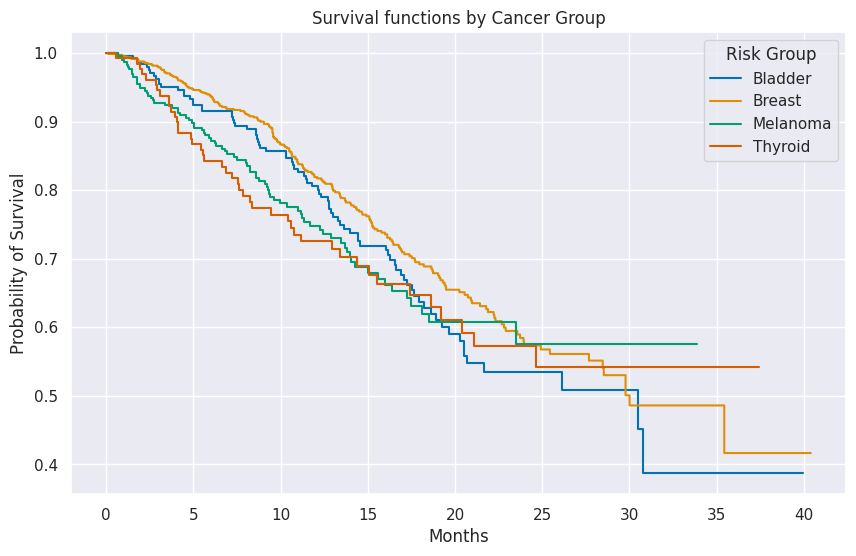

In [14]:
kmf = KaplanMeierFitter()

# Get the unique risk groups
risks_types = df_multiclass_survival['Cancer Group'].unique()

# Prepare the plot
plt.figure(figsize=(10, 6))  # Set a figure size

median_survival_time_real = []
average_survival_time_real = []
variance_survival_time_real = []

# Loop through each risk group
for risk_type in risks_types:
    # Select data for the current risk group
    ix = df_multiclass_survival['Cancer Group'] == risk_type
    # Fit the Kaplan-Meier model
    kmf.fit(T[ix], E[ix], label=risk_type)
    # Plot the survival function for the current group
    kmf.plot_survival_function(ci_show=False)
    median_survival_time_real.append(kmf.median_survival_time_)
    average_survival_time_real.append(kmf.survival_function_.mean())
    variance_survival_time_real.append(kmf.survival_function_.var())

# Customize the plot
plt.title('Survival functions by Cancer Group')
plt.xlabel('Months')
plt.ylabel('Probability of Survival')
plt.legend(title='Risk Group')

# Show the plot
plt.show()

# $\varepsilon$-DP Obfuscation Method

In [15]:
# check if the possible epsilon is negative
def verify_epsilon(p,n):
    epsilon = np.log((n*p+1-p)/(n-1-n*p+p))
    if epsilon <= 0:
        print('epsilon is negative for such values of p and n')
        exit()
    else:
        return epsilon

In [16]:
def revised_coin_toss(category, list_of_uniques, n, p):

    '''
    category: IPSS-R category, value to be privatized
    n: number of categories (not used in this function, used to compute the epsilon)
    p: coin bias
    '''    
    # compute epsilon
    epsilon = verify_epsilon(p,n)

    # toss a coin H with probability p, T with probability 1-p
    coin = np.random.choice(['H', 'T'], p=[p, 1-p])

    # if coin is H, return the original value
    if coin == 'H':
        return category
    
    # if coin is T, return a random value from the n categories
    else:
        return random.choice(list_of_uniques)


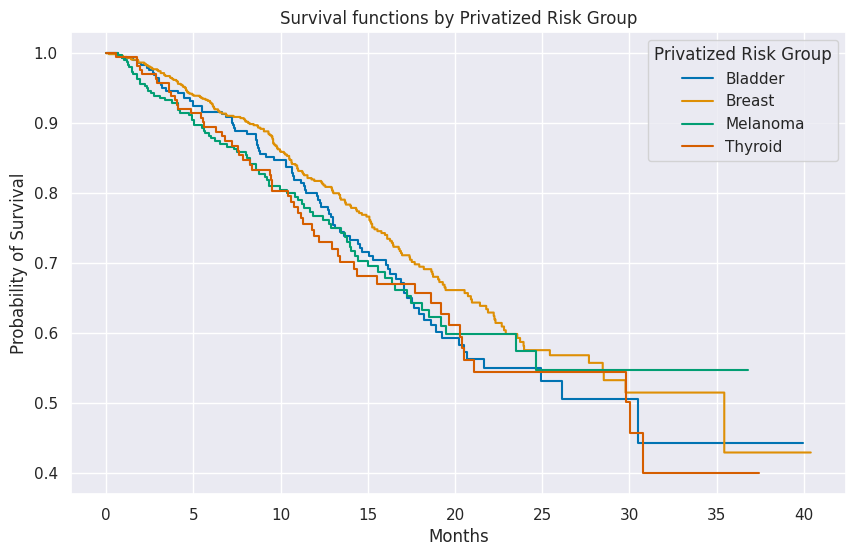

The epsilon for the privatized data is:  1.7346010553881066


In [17]:
# set the coin bias
p_1 = 0.8
n = len(risks_types)
e1 = verify_epsilon(p_1, n)
# privatize the IPSS-R category
df_multiclass_survival['Privatized Cancer Group'] = df_multiclass_survival['Cancer Group'].apply(lambda x: revised_coin_toss(x, risks_types, n, p_1))


kmf = KaplanMeierFitter()

T = df_multiclass_survival['Time (months)']
E = df_multiclass_survival['Status']

# Prepare the plot
plt.figure(figsize=(10, 6))  # Set a figure size

median_survival_time_dp = []
average_survival_time_dp = []
variance_survival_time_dp = []

# Loop through each risk group
for risk_type in risks_types:
    # Select data for the current risk group
    ix = df_multiclass_survival['Privatized Cancer Group'] == risk_type
    # Fit the Kaplan-Meier model
    kmf.fit(T[ix], E[ix], label=risk_type)
    # Plot the survival function for the current group
    kmf.plot_survival_function(ci_show=False)
    median_survival_time_dp.append(kmf.median_survival_time_)
    average_survival_time_dp.append(kmf.survival_function_.mean())
    variance_survival_time_dp.append(kmf.survival_function_.var())

# Customize the plot
plt.title('Survival functions by Privatized Risk Group')
plt.xlabel('Months')
plt.ylabel('Probability of Survival')
#sort the legend
plt.legend(title='Privatized Risk Group', loc='best')

# Show the plot
plt.show()

print('The epsilon for the privatized data is: ', e1)


In [18]:
results = lifelines.statistics.pairwise_logrank_test(df_multiclass_survival['Time (months)'], df_multiclass_survival['Cancer Group'], df_multiclass_survival['Status'])

In [19]:
#parse the list of average survival times so that only the numeric values are left
average_survival_time_real = [x._values[0] for x in average_survival_time_real]
average_survival_time_dp = [x._values[0] for x in average_survival_time_dp]

#parse the list of variance survival times so that only the numeric values are left
variance_survival_time_real = [x._values[0] for x in variance_survival_time_real]
variance_survival_time_dp = [x._values[0] for x in variance_survival_time_dp]

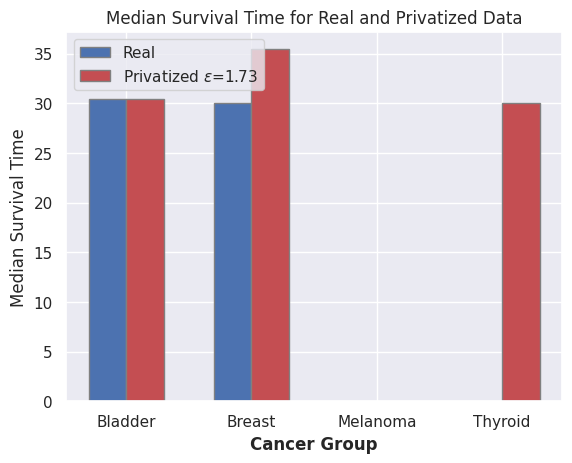

In [20]:
#plot a barplot with the median survival time for the real and privatized data
fig, ax = plt.subplots()
barWidth = 0.3
bars1 = median_survival_time_real
bars2 = median_survival_time_dp
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, color='b', width=barWidth, edgecolor='grey', label='Real')
plt.bar(r2, bars2, color='r', width=barWidth, edgecolor='grey', label=r'Privatized $\varepsilon$=' + f'{e1:.2f}')

plt.xlabel('Cancer Group', fontweight='bold')
plt.xticks([r + 0.5*barWidth for r in range(len(bars1))], risks_types)
plt.ylabel('Median Survival Time')
plt.title('Median Survival Time for Real and Privatized Data')
plt.legend(loc='best')
plt.show()

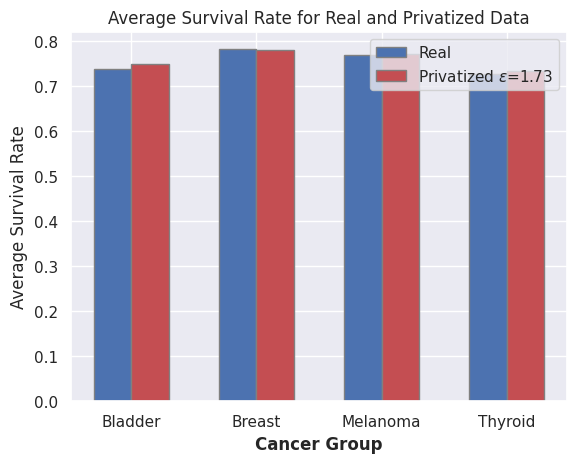

In [21]:
#plot a barplot with the average survival time for the real and privatized data
fig, ax = plt.subplots()
barWidth = 0.3
bars1 = average_survival_time_real
bars2 = average_survival_time_dp
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, color='b', width=barWidth, edgecolor='grey', label='Real')
plt.bar(r2, bars2, color='r', width=barWidth, edgecolor='grey', label=r'Privatized $\varepsilon$=' + f'{e1:.2f}')

plt.xlabel('Cancer Group', fontweight='bold')
plt.xticks([r + 0.5*barWidth for r in range(len(bars1))], risks_types)
plt.ylabel('Average Survival Rate')
plt.title('Average Survival Rate for Real and Privatized Data')
plt.legend()
plt.show()

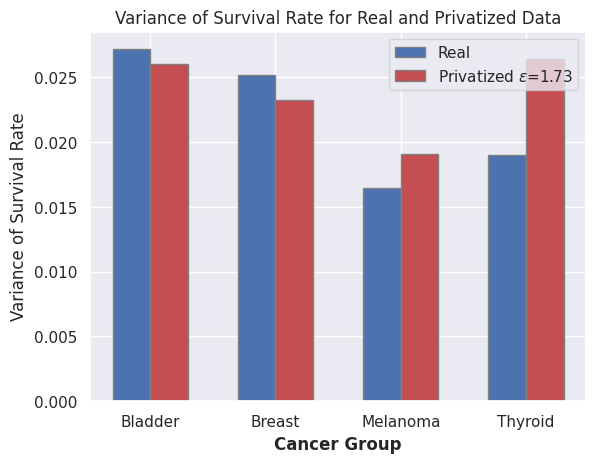

In [22]:
#plot a barplot with the variance of the survival time for the real and privatized data
fig, ax = plt.subplots()
barWidth = 0.3
bars1 = variance_survival_time_real
bars2 = variance_survival_time_dp

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, color='b', width=barWidth, edgecolor='grey', label='Real')
plt.bar(r2, bars2, color='r', width=barWidth, edgecolor='grey', label=r'Privatized $\varepsilon$=' + f'{e1:.2f}')

plt.xlabel('Cancer Group', fontweight='bold')
plt.xticks([r + 0.5*barWidth for r in range(len(bars1))], risks_types)
plt.ylabel('Variance of Survival Rate')
plt.title('Variance of Survival Rate for Real and Privatized Data')
plt.legend(loc='best')
plt.show()

In [23]:
#compare the logrank test for the original and privatized data
results_dp = lifelines.statistics.pairwise_logrank_test(df_multiclass_survival['Time (months)'], df_multiclass_survival['Privatized Cancer Group'], df_multiclass_survival['Status'])

In [24]:
#plot results as a clear table
print('Privatized Data')
results_dp.print_summary()
print('Real Data')
results.print_summary()

Privatized Data


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
                   test_statistic    p  -log2(p)
Bladder  Breast              2.01 0.16      2.68
         Melanoma            0.01 0.91      0.14
         Thyroid             0.17 0.68      0.55
Breast   Melanoma            2.41 0.12      3.05
         Thyroid             2.72 0.10      3.33
Melanoma Thyroid             0.16 0.69      0.53

Real Data


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
                   test_statistic    p  -log2(p)
Bladder  Breast              1.77 0.18      2.45
         Melanoma            0.14 0.71      0.50
         Thyroid             0.13 0.72      0.48
Breast   Melanoma            3.94 0.05      4.41
         Thyroid             2.14 0.14      2.80
Melanoma Thyroid             0.15 0.70      0.51